In [1]:
import sqlite3 as lite
import os
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image
import matplotlib.pyplot as plt
import os
from shutil import copyfile

In [2]:
import analysis as an

/home/teddy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/home/teddy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


In [3]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('./output/2020_lwr.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

In [4]:
# get number of reactors and capacity timeseries
an.plot_power(cur)

Sink_Source_Inst has no values
Sink_Source_Inst has no values


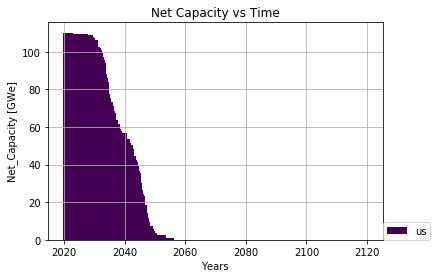

In [5]:
Image('power_plot.png')

In [6]:

def get_dep_array_once(sfr_avail, growth_rate, old_cap):
    # automatically calculated values
    scenario_name = '%i_%s_growth' %(sfr_avail, str(growth_rate).replace('.','_'))
    demand_eq = '110*(%s)**(t/12)' %str(1+growth_rate)
    avail_timestep = (sfr_avail* 12) - (2013*12 + 5)

    # get lwr_only, find deployment scheme for lwr and sfr
    cur = an.get_cursor('./output/2020_lwr.sqlite')
    init_year, init_month, duration, timestep = an.get_timesteps(cur)
    power_dict = an.get_power_dict(cur)
    dep_array, dep_power = an.get_new_deployment(power_dict, ['us_government'],
                                                 demand_eq, old_cap, 240)
    return dep_array


dep_dict = {}
new_avail = 2050
growth_rate = 0.015
scenario_name = 'smr_msr'
smr_dep=get_dep_array_once(new_avail, growth_rate, 0.72)
dep_dict[scenario_name] = {'smr': smr_dep}




timestep 0 is not done correctly
It has a powercap of 0.000000 when it should have 110.000000


timestep 0 is not done correctly
It has a powercap of 0.000000 when it should have 110.000000
timestep 0 is not done correctly
It has a powercap of 0.000000 when it should have 110.000000


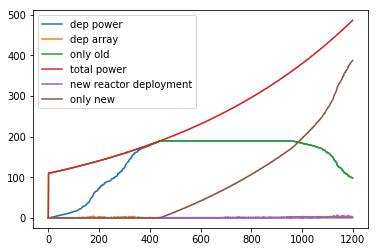

In [10]:

def get_dep_arrays(sfr_avail, growth_rate, old_cap, new_cap, old_life, new_life):
    # automatically calculated values
    scenario_name = '%i_%s_growth' %(sfr_avail, str(growth_rate).replace('.','_'))
    demand_eq = '110*(%s)**(t/12)' %str(1+growth_rate)
    avail_timestep = (sfr_avail* 12) - (2013*12 + 5)

    # get lwr_only, find deployment scheme for lwr and sfr
    cur = an.get_cursor('./output/2020_lwr.sqlite')
    init_year, init_month, duration, timestep = an.get_timesteps(cur)
    power_dict = an.get_power_dict(cur)
    dep_array, dep_power = an.get_new_deployment(power_dict, ['us_government'],
                                                 demand_eq, old_cap, old_life)
    for indx in range(len(dep_array)):
        if indx > avail_timestep:
            dep_array[indx] = 0
    # recalculate power
    dep_power = np.zeros(len(dep_array))
    for indx, val in enumerate(dep_array):
        if val != 0:
            top = min(indx+960, duration)
            for i in range(indx, top):
                dep_power[i] += val * old_cap
    plt.plot(dep_power, label='dep power')
    plt.plot(dep_array, label='dep array')

    new_power = {'power': power_dict['us_government'] + dep_power}
    plt.plot(new_power['power'], label='only old')

    sfr_dep, sfr_power = an.get_new_deployment(new_power, ['power'], demand_eq,
                                               new_cap, new_life)
    plt.plot(new_power['power'] + sfr_power, label='total power')
    plt.plot(sfr_dep, label='new reactor deployment')
    plt.plot(sfr_power, label='only new')
    plt.legend()
    plt.show()
    plt.close()
    return dep_array, sfr_dep


dep_dict = {}
new_avail = 2050
growth_rate = 0.015
scenario_name = 'smr_msr'
smr_dep, sfr_dep =get_dep_arrays(new_avail, growth_rate, 0.72, 0.82, 960, 240)
dep_dict[scenario_name] = {'smr': smr_dep, 'msr': sfr_dep}


In [11]:
# write these deploy schemes to file
for key in dep_dict.keys():
    if not os.path.isdir("./%s" %key):
        print('FOLDER %s NOT THERE,' %key)
        os.makedirs(key)    
        print('%s FOLDER MADE!' %key)
    try:
        os.remove('./%s/input.xml' %key)
    except:
        print('./%s/input.xml DOES NOT EXIST'%key)
    copyfile('./2020.xml', './%s/input.xml' %key)
    for key2 in dep_dict[key]:
        an.write_deployinst(dep_dict[key][key2], key2, './%s/%s_dep.xml' %(key, key2),
                            240)

In [8]:
# delete sqlite files
for key in dep_dict.keys():
    if os.path.isfile('./%s/output.sqlite' %key):
        os.remove('./%s/output.sqlite' %key)
        print('REMOVED %s' %key)

REMOVED 2035_0_005_growth
